## Examples of GeoPandas and KeplerGL using London crime data

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Import necessary modules
import geopandas as gpd
import fiona
import geoplot
import dask 
import vaex
from keplergl import KeplerGl
import requests
import logging
from requests.exceptions import HTTPError, ConnectionError
import sys
import mapclassify
import geoplot
import rtree
# wget http://aprsworld.net/gisdata/world/world.zip
#fp = "L2_data/DAMSELFISH_distributions.shp"
# Read file using gpd.read_file()
#data = gpd.read_file(fp)

# this will remove the root logger and avoid duplicate logs in notebook
for handler in logging.getLogger().handlers:
    logging.getLogger().removeHandler(handler)
    
logger = logging.getLogger()
handle = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handle.setFormatter(formatter)
logger.addHandler(handle)
logger.setLevel(logging.INFO)

### Loading london shape files and switching to EPSG coordinate system (lat/lon)

In [2]:

london_map = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
london_map = london_map.to_crs(epsg=4326) 
 # for mercator projection we could use epsg=3395
# for this map
london_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [3]:
# get rid of the columns we do not need

london_map = london_map.loc[:, ['NAME', 'GSS_CODE', 'geometry']].rename({'NAME': 'borough'})
london_map.head(10)

# we will use this to plot the basemap later when we overlay data on top of it

,NAME,GSS_CODE,geometry
0,Kingston upon Thames,E09000021,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,Croydon,E09000008,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861..."
2,Bromley,E09000006,"POLYGON ((0.01213 51.29960, 0.01196 51.29980, ..."
3,Hounslow,E09000018,"POLYGON ((-0.24456 51.48870, -0.24468 51.48868..."
4,Ealing,E09000009,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412..."
5,Havering,E09000016,"POLYGON ((0.15869 51.51219, 0.15871 51.51224, ..."
6,Hillingdon,E09000017,"POLYGON ((-0.40407 51.61318, -0.40388 51.61229..."
7,Harrow,E09000015,"POLYGON ((-0.40407 51.61318, -0.40320 51.61318..."
8,Brent,E09000005,"POLYGON ((-0.19657 51.52765, -0.19685 51.52773..."
9,Barnet,E09000003,"POLYGON ((-0.19990 51.67017, -0.19970 51.66986..."


### Now lets call the data.police API and fetch some crime data for London

In [4]:
import os
from functools import partial

url_base="https://data.police.uk/api/"
ignored_outcomes = ['A no further action disposal', False, '']

def get_request(url):
    response=requests.get(url, timeout=30)
    try:
    # If the response was successful, no Exception will be raised
        response.raise_for_status()
    except HTTPError as http_err:
        logger.exception(f'HTTP error occurred: {http_err}')
    except Exception as err:
        pass
        logger.exception(f'Other error occurred: {err}')
    else:
        logger.info(f'HTTP request for {url} was successful!')

    response.encoding = 'utf-8'
    
    return response.json()

def get_neighbourhoods(get_request, police_id):
    
    url = os.path.join(url_base, f"{police_id}/neighbourhoods")

    return get_request(url)

def get_stop_search_by_force(get_request, police_id, date=None):
    """
    Retrieve stop and search data for a given police force. if date is not provided,
    returns all stop and search data which have lead to outcomes like arrest, court summons
    for latest month(s).Also removes any data with no location info
    """
    
    new_list = []
    if date is None:
        url = os.path.join(url_base, f"stops-force?force={police_id}")
    else:
        url = os.path.join(url_base, f"stops-force?force={police_id}&date={date}")
    response = get_request(url)
    for json in response:
        if (json.get('outcome') not in ignored_outcomes) and (json.get('location') is not None):
            new_list.append(json)
        
    logger.info(f"Successfully fetched data from month: {date}")
    return new_list


def available_data_dates(get_request, force_id, months=3):
    """
    returns availble dates - data available for given force id
    and recent number of available months
    """
    
    url = os.path.join(url_base, "crimes-street-dates")
    
    response = get_request(url)
    
    available_dates = []
    
    for json in response:
        if len(available_dates) == months:
            break
        else:
            if 'metropolitan' in json.get('stop-and-search'):
                available_dates.append(json.get('date'))
                
                
    logger.info(f'The available dates are {",".join(available_dates)}')

    return None
    
    
def get_police_id(get_request, force_name):
    """
    Get police id and police force names in json
    """
    url = os.path.join(url_base, "forces")
    response = get_request(url)
    for json in response:
        if json.get('name') == force_name:
            police_id = json.get('id')
            break
            
    logger.info(f"Police id for {force_name}:- '{police_id}'")
    
    return police_id

In [5]:
#force_name='Avon and Somerset Constabulary'
force_name='Metropolitan Police Service'
police_id = get_police_id(get_request, force_name)

#get_stop_search_by_force(get_request, police_id,date='2019-03')
available_data_dates(get_request, police_id)
neighbourhoods = get_neighbourhoods(get_request, police_id)
    
crime_london_json = get_stop_search_by_force(get_request, police_id, date='2018-05')

2020-06-25 20:31:28,302 - root - INFO - HTTP request for https://data.police.uk/api/forces was successful!
2020-06-25 20:31:28,304 - root - INFO - Police id for Metropolitan Police Service:- 'metropolitan'
2020-06-25 20:31:28,858 - root - INFO - HTTP request for https://data.police.uk/api/crimes-street-dates was successful!
2020-06-25 20:31:28,860 - root - INFO - The available dates are 2020-03,2020-02,2020-01
2020-06-25 20:31:29,367 - root - INFO - HTTP request for https://data.police.uk/api/metropolitan/neighbourhoods was successful!
2020-06-25 20:31:53,465 - root - INFO - HTTP request for https://data.police.uk/api/stops-force?force=metropolitan&date=2018-05 was successful!
2020-06-25 20:31:53,556 - root - INFO - Successfully fetched data from month: 2018-05


In [6]:
print(f'We have {len(crime_london_json)} street search arrests with location information')


We have 3210 street search arrests with location information


### Convert to Geopandas dataframe after reassinging types and removing some columns

In [7]:
data = pd.DataFrame(crime_london_json)
data['latitude'] = data['location'].map(lambda x: np.float(x['latitude']))
data['longitude'] = data['location'].map(lambda x: np.float(x['longitude']))
data['datetime'] = data['datetime'].astype('datetime64[ns]')
data['gender'] = data['gender'].astype ('category')
data['outcome'] = data['outcome'].astype ('category')
data = data[['datetime', 'latitude', 'longitude','outcome', 'gender', 'object_of_search']]

geo_ds = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.longitude, data.latitude))
geo_ds.head()

,datetime,latitude,longitude,outcome,gender,object_of_search,geometry
0,2018-05-02 07:00:00,51.513873,-0.178017,Arrest,Male,Stolen goods,POINT (-0.17802 51.51387)
1,2018-05-04 09:10:00,51.471396,-0.455787,Community resolution,Male,Controlled drugs,POINT (-0.45579 51.47140)
2,2018-05-09 01:35:00,51.475074,-0.493087,Community resolution,Male,Stolen goods,POINT (-0.49309 51.47507)
3,2018-05-10 08:05:00,51.469708,-0.451842,Community resolution,Female,Stolen goods,POINT (-0.45184 51.46971)
4,2018-05-13 17:10:00,51.500632,-0.420192,Community resolution,Male,Controlled drugs,POINT (-0.42019 51.50063)


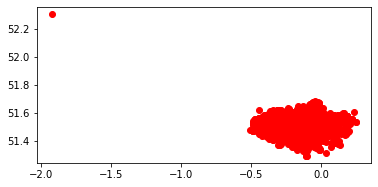

In [8]:
geo_ds.plot(color='red')

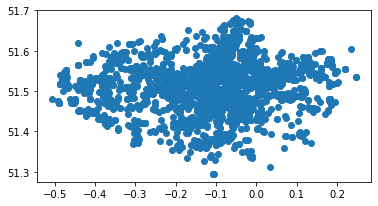

In [9]:
# there is some random point in wrong latitude/long in top left corner outside Londo - lets get rid of it

geo_ds = geo_ds.loc[geo_ds['longitude'] > -1, :]

geo_ds.plot()

### Now lets plot on top of basemap using Geopandas df of UK map we created earlier

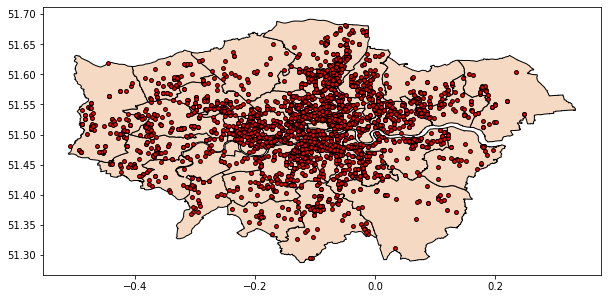

In [10]:
geo_ds.crs = "epsg:4326"
ax = london_map.plot(color=(0.96,0.85,0.76), edgecolor='black', figsize=(10,10))
geo_ds.plot(ax=ax, edgecolor='black', color='red', markersize=15)
plt.show()

### Now create a cholorpeth map so we can visualise number of crimes via colour scheme and group by other columns

In [46]:
merged_df = gpd.sjoin(london_map, geo_ds, how="inner", op='intersects')
merged_df['outcome'] = merged_df['outcome'].cat.rename_categories({'Caution (simple or conditional)':'Caution', 
                                                              'Khat or Cannabis warning':'Drugs warning',
                                                              'Penalty Notice for Disorder':'Penalty Notice for Disorder',
                                                              'Summons / charged by post': 'Summons'})


In [121]:

total_crimes_borough = merged_df.groupby(['NAME'])['outcome'].count().reset_index()

df_chloro = merged_df[['NAME', 'geometry']].merge(total_crimes_borough, how='inner', on='NAME').rename({'outcome':'crimes'}, axis='columns')
df_chloro = df_chloro.drop_duplicates().reset_index(drop=True)

/Users/rk1103/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/mapclassify/classifiers.py:235: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
/Users/rk1103/opt/anaconda3/envs/geospatial/lib/python3.8/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 96
  Warn("Warning: setting k to %d" % k_q, UserWarning)


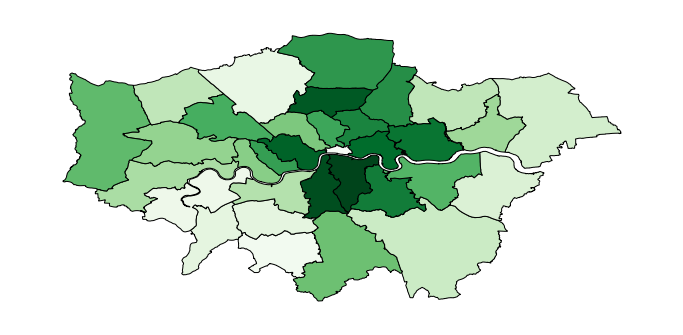

In [135]:
scheme = mapclassify.Quantiles(df_chloro['crimes'], k=100)
geoplot.choropleth(df_chloro, hue=df_chloro['crimes'], scheme=scheme, cmap='Greens', figsize=(12, 12))